In [1]:
!pip3 install numpy

In [122]:
import numpy as np
import pandas as pd
import sys
import nltk
import seaborn as sns

import spacy
import time
from sklearn import svm
from sklearn.metrics import classification_report
from nltk.tokenize.toktok import ToktokTokenizer
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import collections
from nltk import pos_tag_sents
from nltk.corpus import reuters
import re,string,unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
from sklearn.svm import LinearSVC

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

movie_data = pd.read_csv("IMDB Dataset.csv")
print(movie_data.shape)
movie_data.head(10) # first 10 data examples

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
movie_data["sentiment"].value_counts() # positive/negative sentiment counts

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [4]:
training_set = movie_data.review[0:40000] # 80% of dataset as training
training_sentiments = movie_data.sentiment[0:40000] # sentiments for training set

#test set
test_set = movie_data.review[40000:50000]
test_sentiments = movie_data.sentiment[40000:50000]
print(training_set.shape, training_sentiments.shape) # 40,000 examples in training set
print(test_set.shape, test_sentiments.shape) # 10,000 examples in test set


(40000,) (40000,)
(10000,) (10000,)


In [5]:
# TESTIN DNT USE LMAO xD
#training_set = movie_data.review[0:1000] # 80% of dataset as training
#training_sentiments = movie_data.sentiment[0:1000] # sentiments for training set

#test set
#test_set = movie_data.review[1001:2001]
#test_sentiments = movie_data.sentiment[1001:2001]
#print(training_set.shape, training_sentiments.shape) # 40,000 examples in training set
#print(test_set.shape, test_sentiments.shape) # 10,000 examples in test set


In [6]:
tokenizer = ToktokTokenizer() # tokenizer 
stopwords_list = nltk.corpus.stopwords.words('english') # get english stopwords from ntlk corpus
#removing special chars
def remove_special_chars(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text) #removing non alphanumeric chars
    return text
movie_data['review'] = movie_data['review'].apply(remove_special_chars)

In [7]:


#Removing the noisy text
def remove_noise(text):
    #remove html
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    #remove square brackets
    text = re.sub('\[[^]]*\]', '', text)
    return text
#Apply function on review column
movie_data['review'] = movie_data['review'].apply(remove_noise)

In [8]:
#text stemming
def stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()]) #get each word from text, get stem
    #then put together all the stems
    return text

movie_data['review'] = movie_data['review'].apply(stemmer)
    

In [9]:
stop_words = set(stopwords.words('english'))
print(stop_words)

def remove_stopwords(text, is_lower_case = False):
    tokens = tokenizer.tokenize(text) #tokenized text
    tokens = [token.strip() for token in tokens] #strip each token and store in list
    
    if not is_lower_case:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords_list]
    else:
        filtered_tokens = [token for token in tokens if token not in stopwords_list]
        
    filtered_text =  ' '.join(filtered_tokens) #stopwords
    return filtered_text

movie_data['review'] = movie_data['review'].apply(remove_stopwords)


{'where', 'don', 'were', 'them', 'having', 'than', "didn't", "needn't", 'above', 'her', 'because', "you'll", 'not', 're', 'itself', 'm', 'between', 'hers', 'during', 'below', "isn't", 'here', 'your', 'me', 'that', 'aren', 'we', 'ourselves', 'now', 'out', 'who', 'their', 'there', 'will', 'ma', "you're", 'from', 'other', 've', 'most', 'same', 'd', "shan't", 'does', "you'd", 'doesn', 'how', 'of', 'wasn', 'won', 'those', 'have', "aren't", 'hasn', 'ours', 'with', 'weren', 'into', 'further', 'myself', 'should', 'him', 'through', 'or', 'any', 'be', 'hadn', 'did', "it's", 'after', 'it', 'do', 'o', 'and', 'y', 'by', 'under', "won't", "hasn't", 'no', "don't", 'mustn', 'being', 'shouldn', 'shan', "mightn't", 'but', 'am', 'such', "doesn't", 'so', 'only', 'doing', 'very', 'ain', 'once', 'theirs', 'up', 'all', "weren't", "shouldn't", 'for', 'why', 'an', 'll', 'whom', 'if', 'its', 'a', 'in', 'too', 'about', 'has', 'couldn', 'these', 't', "couldn't", "wasn't", 'down', 'yours', 's', 'can', 'mightn', "h

In [10]:
normalized_train_reviews = movie_data['review'][:40000]

# TESTING ONLY DONT USE xD
#normalized_train_reviews = movie_data['review'][:1000]

# normalized_train_string=normalized_train_reviews.to_string() # convert reviews to strings
# normalized_train_spelling=TextBlob(normalized_train_string)
# normalized_train_spelling.correct() # fix spelling
# normalized_train_words=normalized_train_spelling.words
# normalized_train_words

In [12]:
# import spacy

# nlp = spacy.load("en_core_web_sm")
# doc = nlp(normalized_train_reviews[12])

# for ent in doc.ents:
#     print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [13]:
normalized_test_reviews = movie_data['review'][40000:]
normalized_test_reviews[45000]

#normalized_test_reviews = movie_data['review'][1001:2001]
#print(normalized_test_reviews.shape)
#print(normalized_train_reviews.shape)

'enjoy thi film wa sceneri corfu greek ador countri like flatter director point view base true stori dure year greec wa struggl stand two feet war nazi hardship italian soldier greek girl fall love time hard lot sacrific make nichola cage look great uniform give passion account thi unfulfil begin love ador christian bale play mandra heroin husbandtob look veri veri good greek hi person match one greek patriot true fighter one movi would like buy keep collectionfor ever'

In [99]:
#cv=CountVectorizer(min_df=0,max_df=1,binary=True,ngram_range=(1,4))
cv=CountVectorizer(binary=True, ngram_range=(1,4))
# cv=CountVectorizer(binary=True)



In [100]:
# cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,4))
#transformed train reviews
cv_train_reviews=cv.fit_transform(normalized_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(normalized_test_reviews)

#svm reviews
# svm_train_reviews = cv.fit(normalized_train_reviews)
# svm_test_reviews = cv.transform(normalized_train_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (40000, 11943623)
BOW_cv_test: (10000, 11943623)


In [16]:
#ngram up to 4


In [101]:
tv=TfidfVectorizer(ngram_range=(1,4))
#transformed train reviews
tv_train_reviews=tv.fit_transform(normalized_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(normalized_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 11943623)
Tfidf_test: (10000, 11943623)


In [102]:
#changing positive and negative labels to binary format
binary=LabelBinarizer()
#transformed sentiment data
sentiment_data=binary.fit_transform(movie_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


In [19]:
print(sentiment_data)

[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]


In [103]:
#split data 80 20
train_sentiments=sentiment_data[0:40000]
test_sentiments=sentiment_data[40000:]

In [21]:
 # DNT USE
#train_sentiments=sentiment_data[0:1000]
#test_sentiments=sentiment_data[1001:2001]

In [104]:
#train model with logistic regression
logistic=LogisticRegression(penalty='l2',max_iter=500,C=.25,random_state=42)
#Fitting the model for Bag of words
logistic_bow=logistic.fit(cv_train_reviews,train_sentiments)
#print(logistic_bow)
#Fitting the model for tfidf features
logistic=LogisticRegression(penalty='l2',max_iter=500,C=.25,random_state=42)
logistic_tfidf=logistic.fit(tv_train_reviews,train_sentiments)
print(logistic_tfidf)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.25, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [105]:
#Predicting the model for bag of words
logistic_bow_predict=logistic_bow.predict(cv_test_reviews)
print(logistic_bow_predict)
##Predicting the model for tfidf features
logistic_tfidf_predict=logistic_tfidf.predict(tv_test_reviews)
print(logistic_tfidf_predict)

[0 0 1 ... 0 0 0]
[0 0 0 ... 1 0 0]


In [106]:
#Accuracy score for CV
logistic_bow_score=accuracy_score(test_sentiments,logistic_bow_predict)
print("logistic CV score :",logistic_bow_score)
#Accuracy score for tfidf features
logistic_tfidf_score=accuracy_score(test_sentiments,logistic_tfidf_predict)
print("logistic regression tfidf score :",logistic_tfidf_score)

logistic CV score : 0.8952
logistic regression tfidf score : 0.8596


In [84]:
#report - logstici regression
#accuracy for 3 ngram - 75% BOW 68%
#accuracy for 4 ngram - 76% BOW 59
#with mindf 0 maxdf 1


logistic_bow_report = classification_report(test_sentiments, logistic_bow_predict, target_names=['Positive', 'Negative'])
print(logistic_bow_report)

              precision    recall  f1-score   support

    Positive       0.90      0.90      0.90      4993
    Negative       0.90      0.91      0.90      5007

   micro avg       0.90      0.90      0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [60]:
logistic_tfidf_report = classification_report(test_sentiments, logistic_tfidf_predict, target_names=['Positive', 'Negative'])
print(logistic_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.86      0.87      0.87      4993
    Negative       0.87      0.86      0.87      5007

   micro avg       0.87      0.87      0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [107]:
#training the linear svm
#svm=SGDClassifier(loss='hinge',n_iter=500,random_state=42)
svm = LinearSVC()
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments)
print(svm_bow)
svm = LinearSVC()
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


In [108]:
#Predicting the model for bag of words
svm_bow_predict=svm_bow.predict(cv_test_reviews)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm_tfidf.predict(tv_test_reviews)
print(svm_tfidf_predict)
#report = classification_report(test_sentiments, svm_bow_predict, target_names=[0,1], output_dict=True)
#print(report)

[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [30]:
report = classification_report(test_sentiments, svm_bow_predict, target_names=["Negative", "Positive"])
print(report)

              precision    recall  f1-score   support

    Negative       0.90      0.89      0.90      4993
    Positive       0.89      0.90      0.90      5007

   micro avg       0.90      0.90      0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [109]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.8975
svm_tfidf_score : 0.9022


<function matplotlib.pyplot.show(*args, **kw)>

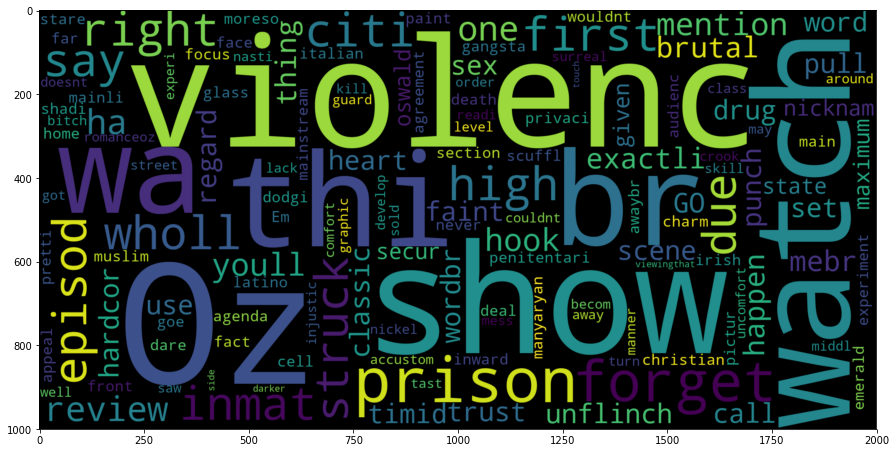

In [32]:
#word cloud for positive review words
plt.figure(figsize=(15,15))
positive_text=normalized_train_reviews[0]
WC=WordCloud(width=2000,height=1000,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

19993
20007


<function matplotlib.pyplot.show(*args, **kw)>

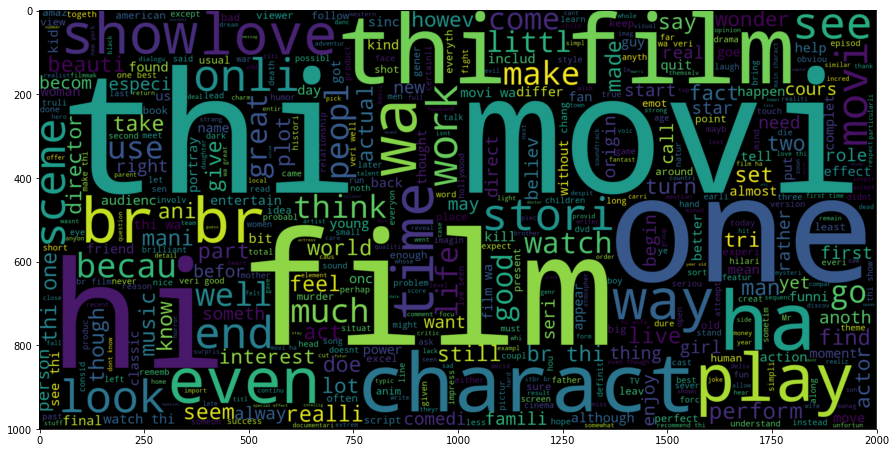

In [40]:
# spelling_test = TextBlob(normalized_train_reviews[1])
# words = str(spelling_test.correct())
# print(words)

from collections import Counter

positive_reviews = []
negative_reviews = []
normalized_text_split = (normalized_train_reviews[1].split())
for i, sent in enumerate(train_sentiments):
    if sent == 1:
        positive_reviews.append(normalized_train_reviews[i])
    else:
        negative_reviews.append(normalized_train_reviews[i])
#word cloud for positive review words
plt.figure(figsize=(15,15))

print(len(positive_reviews))
print(len(negative_reviews))
positive_text=''.join(positive_reviews)
WC=WordCloud(width=2000,height=1000,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show



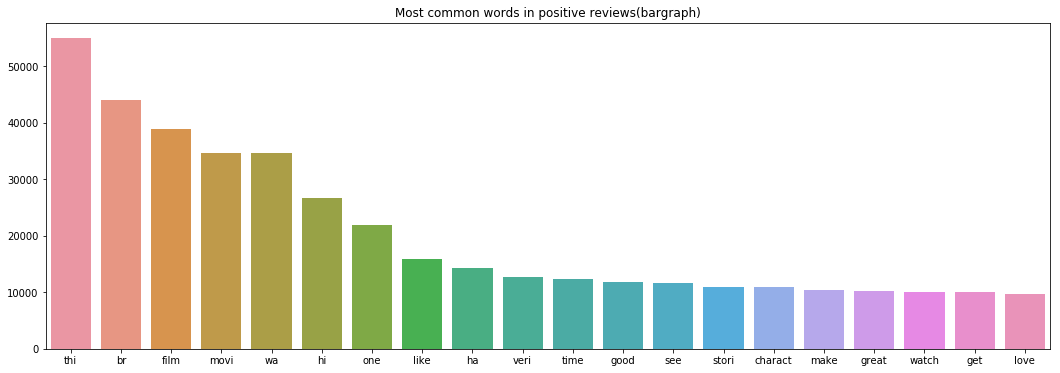

In [124]:
words = []
for review in positive_reviews:
    review_split = review.split()
    for word in review_split:
        words.append(word)

word_count = Counter(words)

most_common_words = [word[0] for word in word_count.most_common(20)]
most_common_words_count = [word[1] for word in word_count.most_common(20)]
fig = plt.figure(figsize=(18,6))
sns.barplot(x=most_common_words, y=most_common_words_count)
plt.title('Most common words in positive reviews(bargraph)')
plt.show()

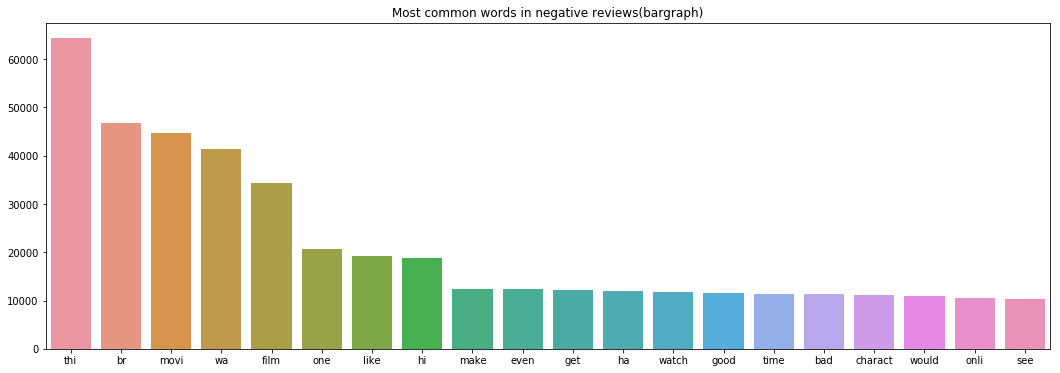

In [125]:
words = []
for review in negative_reviews:
    review_split = review.split()
    for word in review_split:
        words.append(word)

word_count = Counter(words)

most_common_words = [word[0] for word in word_count.most_common(20)]
most_common_words_count = [word[1] for word in word_count.most_common(20)]
fig = plt.figure(figsize=(18,6))
sns.barplot(x=most_common_words, y=most_common_words_count)
plt.title('Most common words in negative reviews(bargraph)')
plt.show()

In [117]:
print(most_common_words)

['thi', 'br', 'film', 'movi', 'wa', 'hi', 'one', 'like', 'ha', 'veri', 'time', 'good', 'see', 'stori', 'charact', 'make', 'great', 'watch', 'get', 'love']


In [ ]:
plt.figure(figsize=(15,15))
negative_text=''.join(negative_reviews)
WC=WordCloud(width=2000,height=1000,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show